<a href="https://colab.research.google.com/github/1901010019/1901010019.github.io/blob/master/transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
!nvidia-smi # to check are we using GPU

Fri Jul  2 18:29:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

downloading and becoming one with the data

In [3]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# now we will unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2021-07-02 18:29:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 172.217.164.176, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   182MB/s    in 0.9s    

2021-07-02 18:29:37 (182 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# walking through 10 percent file direcotry and listing the number of files
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"): 
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

there are 2 directories and 0 images in 10_food_classes_10_percent
there are 10 directories and 0 images in 10_food_classes_10_percent/test
there are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
there are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
there are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
there are 10 directori

preprocessing our image dataset using keras library

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('train data: ')
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               )

print('test data: ')
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               )

train data: 
Found 750 images belonging to 10 classes.
test data: 
Found 2500 images belonging to 10 classes.


setting up callbacks

In [6]:
# callbacks - things to run while our model run
# creating a tensorboard callback
import datetime
def create_tensorboard_callback(dirname, experiment_name):
  log_dir = dirname + '/' + experiment_name + datetime.datetime.now().strftime("%y%m%d-%H%M&S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log files to {log_dir}")
  return tensorboard_callback

In [7]:
# creating models using tensorflow hub
# tensorflow hub is a repository of trained machine learning models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientdet/lite0/feature-vector/1"

In [8]:
image_shape = IMAGE_SHAPE + (3,) # just a different fancy way of writting.
image_shape

(224, 224, 3)

In [9]:
import tensorflow_hub as hub
from tensorflow.keras import layers
# let's make models using our tensorflow hub url's
def create_models(model_url, num_classes=10):
  """
  take the model url and create a keras sequential model
  """
  # download the pretrained model as save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False,
                                           name='feature_extraction_layer', # will not train the already trained parameters
                                           input_shape = image_shape)
  # create our model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               tf.keras.layers.Dense(num_classes, activation='softmax')
  ])

  return model


creating our resnet model

In [10]:
# create resnet model
resnet_model = create_models(resnet_url)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# let's compile our resnet model
resnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [13]:
# let's fit our resnet model to out data
resnet_history = resnet_model.fit(train_data, steps_per_epoch=len(train_data), epochs=5, validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dirname='tensorflow_hub', experiment_name='resnet')])

saving tensorboard log files to tensorflow_hub/resnet210702-1829&S
Epoch 1/5
24/24 [==============================] - 51s 763ms/step - loss: 1.9804 - accuracy: 0.3347 - val_loss: 1.2471 - val_accuracy: 0.5980
Epoch 2/5
24/24 [==============================] - 15s 645ms/step - loss: 0.9349 - accuracy: 0.7160 - val_loss: 0.8798 - val_accuracy: 0.7156
Epoch 3/5
24/24 [==============================] - 15s 642ms/step - loss: 0.6258 - accuracy: 0.8200 - val_loss: 0.7626 - val_accuracy: 0.7504
Epoch 4/5
24/24 [==============================] - 15s 640ms/step - loss: 0.4745 - accuracy: 0.8853 - val_loss: 0.7301 - val_accuracy: 0.7580
Epoch 5/5
24/24 [==============================] - 15s 643ms/step - loss: 0.3873 - accuracy: 0.9120 - val_loss: 0.6973 - val_accuracy: 0.7720


In [14]:
def plot_loss_curves(history):
  loss = history.history['loss']
  accuracy = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()
  
  plt.figure()
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='validation accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

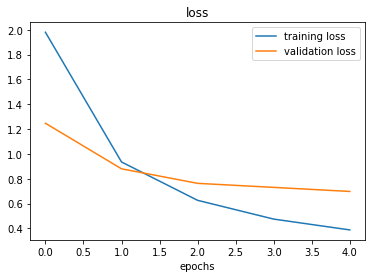

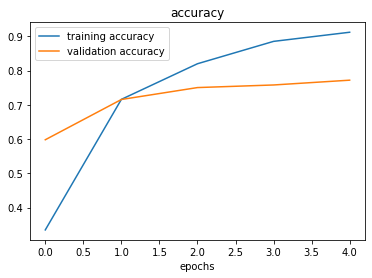

In [15]:
plot_loss_curves(resnet_history)

creating our efficientnet model

In [16]:
# this was we can create a resnet model also.
# efficientnet_model = create_models(efficientnet_url)

# efficientnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
#                      optimizer = tf.keras.optimizers.Adam(),
#                      metrics=['accuracy'])


# efficientnet_history = efficientnet_model.fit(train_data, steps_per_epoch=len(train_data),
#                                               validation_data=test_data,
#                                               validation_steps=len(test_size),
#                                               callbacks=[create_tensorboard_callback(dirname='tensorflow_hub', experiment_name='resnet')]])

In [17]:
len(resnet_model.layers[0].weights) # approximately there are 270 layers in 

270

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'resnet' \
  --description 'observing the performance of our model' \
  --one_shot

our tensorboard is publicly available at 
https://tensorboard.dev/experiment/iOGimjI9QMu0ejzLJXsqkQ/

In [20]:
!tensorboard dev list

2021-07-02 18:39:38.281497: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/iOGimjI9QMu0ejzLJXsqkQ/
	Name                 resnet
	Description          observing the performance of our model
	Id                   iOGimjI9QMu0ejzLJXsqkQ
	Created              2021-07-02 18:33:26 (6 minutes ago)
	Updated              2021-07-02 18:33:27 (6 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  1904395
Total: 1 experiment(s)
